In [ ]:
import os
import datetime
import time
import urllib.request
from argparse import ArgumentParser
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

def yahoo_finance_csv(code : str, 
                      start_from_date : str = '2010-07-01', 
                      end_to_date : str = datetime.date.today().isoformat(), 
                      interval : str = 'd') -> str: #other intervals are 'wk' and 'mo'

    #setting an header to avoid possible errors
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-Agent','Mozilla/5.0')]
    urllib.request.install_opener(opener)
    
    #converting dates from iso format
    start_from_date = datetime.datetime.fromisoformat(start_from_date)
    end_to_date = datetime.datetime.fromisoformat(end_to_date)

    #converting dates to unix time
    start_from_code = int(time.mktime(start_from_date.timetuple()))
    todays_code = int(time.mktime(end_to_date.timetuple()))

    url = f'https://query1.finance.yahoo.com/v7/finance/download/{code}?period1={start_from_code}&period2={todays_code}&interval=1{interval}&events=history&includeAdjustedClose=true'
    
    #Save as a temporary file and return the a (position, HTTP message)
    save_to_path = urllib.request.urlretrieve(url)
    
    pos_saved_csv = save_to_path[0]

    return pos_saved_csv

def quick_tomorrow(code : str, 
                   plot : bool = True,
                   start_from_date : Optional[str] = None,
                   training_to_test_ratio : Optional[float] = None, 
                   n_layers : Optional[int] = None,
                   n_epochs : Optional[int] = None) -> tuple:

      if start_from_date is None:
          start_from_date = '2010-07-01'
      if training_to_test_ratio is None:
          training_to_test_ratio = 0.9
      if n_layers is None:
          n_layers = 4
      if n_epochs is None:
          n_epochs = 10

      fitted_model = Price_Predictor(code = code, start_from_date = start_from_date,
                                     training_to_test_ratio = training_to_test_ratio, 
                                     n_layers = n_layers,
                                     n_epochs = n_epochs, 
                                     fit_at_start = True)

      if plot == True:
          fig, ax = plt.subplots(1, 2, figsize=(18,5))
          fitted_model.plot_data(ax[0])
          fitted_model.plot_results(ax[1])
          plt.legend()
          plt.show()

      tomorrows_value = fitted_model.predict(return_info = False)

      print("Last price was {price:.2f} on {date}".format(price = fitted_model.df['Open'].values[-1],
                                                          date = fitted_model.df['Date'].values[-1]),
            "Next price is predicted to be {:2f}".format(tomorrows_value), sep='\n')
      
      return fitted_model, tomorrows_value

class Price_Predictor():

    def __init__(self, code : str,
                 start_from_date : str = '2010-07-01',
                 end_to_date : str = datetime.date.today().isoformat(),
                 interval : str = 'd',
                 time_stamps : int = 30, 
                 training_to_test_ratio : float = 0.7, 
                 n_layers : int = 4, #minimum input is 2
                 n_epochs : int = 15,
                 verbose : int = 0,
                 load_model : bool = False, 
                 path_load : str = 'model_saved',
                 fit_at_start : bool = False, 
                 days_forward : int = 1): 

        self.code = code
        self.start_from_date = start_from_date
        self.end_to_date = end_to_date
        self.interval = interval
        self.time_stamps = time_stamps
        self.training_to_test_ratio = training_to_test_ratio
        self.n_layers = max(2, n_layers) #it's useless if less than 2
        self.n_epochs = n_epochs
        self.verbose = 0 if verbose < 0 else 2 if verbose > 2 else verbose
        self.load_model = load_model
        self.path_load = path_load

        #get data and preprocessing
        self.df = pd.read_csv(yahoo_finance_csv(code = code, 
                                                start_from_date = self.start_from_date,
                                                end_to_date = self.end_to_date))
        self.df = self.df.dropna().reset_index(drop=True)

        #set the scaler
        self.scale = MinMaxScaler(feature_range = (0, 1))

        #split
        self.split_val = round(len(self.df)*self.training_to_test_ratio)

        #setting the frequency of date ticks for the plots
        self.data_ticks_freq = round(0.25 * self.split_val)
        self.result_ticks_freq = round(0.25 * len(self.df)*(1-self.training_to_test_ratio))

        #initialize the model
        self.model = self.model_initialize(self.n_layers)
        if fit_at_start == True:
            self.test_predictions = self.fit_and_test(days_forward, self.df, self.split_val)


    def model_initialize(self, 
                         n_layers : int, 
                         optimizer : str = 'adam', 
                         loss_metric : str = 'mean_squared_error') -> Sequential:
      
        if self.load_model and os.path.isdir(self.path_load):
            print(f'Loading model from {self.path_load}')
            model = load_model(self.path_load)
        else:
            n_layers = int(self.n_layers) - 1 #the input layer doesn't count
            #initialising the model
            model = Sequential()
            #adding the LSTM layers
            model.add(LSTM(units = 50, return_sequences = True, input_shape = (self.time_stamps, 1)))
            model.add(Dropout(0.2))
            for i in range(n_layers):
                if i < n_layers-1:
                    return_sequences = True
                else:
                    return_sequences = False
                model.add(LSTM(units = 50, return_sequences = return_sequences))
                model.add(Dropout(0.2))
            #adding the output dense layer
            model.add(Dense(units = 1))
            #cmpiling the model with adam and mse
            model.compile(optimizer = optimizer, loss = loss_metric)
        
        return model

    def fit_and_test(self, days_forward : int,
                    df : Optional[pd.DataFrame] = None, 
                    split_val : Optional[int] = None) -> np.array: #this method is not meant to be run by the user
        
        if df is None:
            df = self.df
        if split_val is None:
            split_val = self.split_val

        self.days_forward = max(0, days_forward-1)

        training_set = df.iloc[:split_val-1]
        test_set = df.iloc[split_val:]

        X_train_scaled = self.scale.fit_transform(training_set['Open'].values.reshape(-1,1))

        X_train = []
        y_train = []
        for i in range(self.time_stamps, split_val-1-self.days_forward):
            X_train.append(X_train_scaled[i-self.time_stamps:i, 0])
            y_train.append(X_train_scaled[i+self.days_forward, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        #reshaping the training set for LSTM
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        if self.load_model == False:
            #fitting on the training data
            self.model.fit(X_train, y_train, epochs = self.n_epochs, batch_size = 32, verbose = self.verbose)

        #getting the test set in the same format of the training (meaning a sequence composed of n° of time_stamps)
        to_test = pd.concat((training_set[-self.time_stamps:], test_set))['Open'].values
        to_test = to_test.reshape(-1,1)
        to_test = self.scale.transform(to_test)

        X_test = []
        for i in range(self.time_stamps, len(test_set)+self.time_stamps):
            X_test.append(to_test[i-self.time_stamps:i, 0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        #rescaling the data
        y_pred = self.model.predict(X_test)
        
        self.test_predictions = self.scale.inverse_transform(y_pred)

        return self.test_predictions
    
    def save_model(self, dir : str = 'model_saved'):
        if os.path.isdir(dir):
            response = 0
            while str(response).lower() != 'y' and str(response).lower() != 'n':
                response = input('A model already exists, overwrite? y/n: ')
                if str(response).lower() == 'y':
                    self.model.save(dir)
                elif str(response).lower() == 'n':
                    rename = input('Rename? y/n: ')
                    if str(rename).lower() == 'y':
                        dir = input('Write a dir name: ')
                        self.model.save(dir)
                    else:
                        break
        else:
            self.model.save(dir)

    def plot_data(self, ax = None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(9,5))
        self.df.plot(x='Date', y=['Open'], ax=ax, title=f'{self.code} Price', xticks=np.arange(0, len(self.df), self.data_ticks_freq))
        ax.axvline(self.split_val, c='k', linestyle='--') 
        
        xlim = ax.get_xlim()
        ax.text(round((self.split_val+xlim[0])/2), self.df['Open'].max()*0.99, s='Training Set', horizontalalignment='center')
        ax.text(round((self.split_val+xlim[1])/2), self.df['Open'].min(), s='Test Set', horizontalalignment='center')

    def plot_results(self, ax = None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(9,5))

        test_set = self.df.iloc[self.split_val:]

        ax.plot(test_set['Open'].values, color = 'blue', label = 'Real Price')
        ax.plot(self.test_predictions, color = 'red', label = 'Predicted Price')
        ax.set_title(f'{self.code} Price Prediction (Test Data)')
        ax.set_xlabel('Time')
        ax.set_ylabel('Price')

        ax.set_xticks(np.arange(0, len(test_set), self.result_ticks_freq))
        ax.set_xticklabels(test_set['Date'][np.arange(test_set.index[0], test_set.index[-1], self.result_ticks_freq)])

    def predict(self, input_sequence = None, return_info : bool = True) -> float:
        if input_sequence is None:
            if return_info:
                print(f'No Input sequence provided, the last {self.time_stamps} records of the data downloaded will be used instead.\n')
            input_sequence = self.df.iloc[self.split_val:]['Open'].values
        input_sequence = np.array(input_sequence).ravel().astype('float32')
        
        if len(input_sequence) > self.time_stamps:
            if return_info:
                print(f'\nWARNING: The input sequence on which to forecast is longer than {self.time_stamps}',
                      'which is the input time stamp and the length of array needed in order to get a prediction,'
                      f'the last {self.time_stamps} records will be considered instead.\n')
            input_sequence = input_sequence[-self.time_stamps:]

        elif len(input_sequence) < self.time_stamps:
            raise ValueError(f"The array must be at least {self.time_stamps} in length")
        
        scaled_sequence = self.scale.transform(input_sequence.reshape(-1,1))
        X_to_predict = scaled_sequence.reshape(1,self.time_stamps,1)
        y_predicted = self.model.predict(X_to_predict)
        rescaled = self.scale.inverse_transform(y_predicted)

        if return_info:
            print(f'In {self.days_forward+1} day(s) the price will be:', rescaled.ravel()[0])

        return rescaled.ravel()[0]

    def __get_data_frame__(self) -> pd.DataFrame:
        return self.df

    def __get_training_set__(self) -> pd.DataFrame:
        return self.df.iloc[:self.split_val-1]

    def __get_test_set__(self) -> pd.DataFrame:
        return self.df.iloc[self.split_val:]

    def __get_params__(self) -> dict:
        try:
            self.days_forward
            status_code = 0
        except:
            status_code = 1

        params = {'code' : self.code, 
                  'start_from_date' : self.start_from_date, 
                  'end_to_date' : self.end_to_date, 
                  'interval' : self.interval,
                  'time_stamps' : self.time_stamps, 
                  'training_to_test_ratio' : self.training_to_test_ratio, 
                  'split_val' : self.split_val, 
                  'n_layers' : self.n_layers, 
                  'n_epochs': self.n_epochs, 
                  'load_model' : self.load_model, 
                  'path_load' : self.path_load}

        if status_code == 0:
            params['days_forward'] = self.days_forward+1

        return params

class Predict_Iterator(Price_Predictor):

    def __init__(self, code : str, 
                 start_from_date : str = '2010-07-01', 
                 end_to_date : str = datetime.date.today().isoformat(), 
                 effort : float = 0.5, 
                 time_stamps : int = 30):

        #the effort parameter increases the resulting performances while increasing the computational time, it is suggested to leave it as default
        
        training_to_test_ratio = round((0.9-0.70)*effort+0.70, 2) #I want a minimum of 0.70 and a maximum of 0.9
        idx_epoch = 0 if effort <= 0.6 else 1 if effort <= 0.75 else 2 if effort <= 0.85 else 3
        n_epochs = [2, 5, 10, 15][idx_epoch] #I generally prefer 2 to be quicker
        n_layers = round(4 * effort) #more than 4 layers is not worth the effort

        super().__init__(code = code, 
                         start_from_date = start_from_date, end_to_date = end_to_date, 
                         time_stamps = time_stamps, 
                         training_to_test_ratio = training_to_test_ratio, 
                         n_layers = n_layers, n_epochs = n_epochs)

    def get_predictions(self, days_to_predict : int = 1,
                        predict_from_date : Optional[str] = None) -> list:

        if predict_from_date is not None:
            end_date = datetime.datetime.fromisoformat(self.end_to_date)
            start_date = datetime.datetime.fromisoformat(predict_from_date)
            
            if end_date > start_date:
                position = self.df['Date'].tolist().index(predict_from_date)
                input_sequence = self.df.iloc[position-self.time_stamps:position]['Open'].values

            else:
                raise ValueError("The chosen 'predict_from_date' must be antecedent to the end date selected previously!")
        else:
            input_sequence = self.df.iloc[self.split_val:]['Open'].values

        self.days_to_predict = max(1, days_to_predict)
        predictions = []
        self.stored_models = []

        for n in range(1, self.days_to_predict+1):
            self.fit_and_test(days_forward = n)
            self.stored_models.append(self)
            price_predicted = self.predict(input_sequence = input_sequence, return_info = False)
            predictions.append(price_predicted)
        
        return predictions


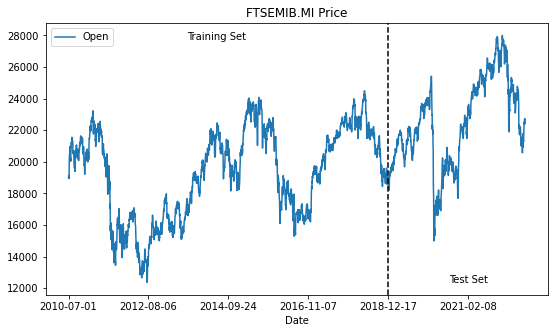

In [ ]:
ftsemib = Price_Predictor('FTSEMIB.MI')
ftsemib.plot_data()

In [ ]:
ftsemib.df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,19000.0,19254.0,18807.0,18944.0,18944.0,1.003573e+09
1,2010-07-02,19114.0,19257.0,18927.0,19074.0,19074.0,7.714960e+08
2,2010-07-05,19127.0,19127.0,18843.0,18849.0,18849.0,4.103019e+08
3,2010-07-06,18945.0,19577.0,18904.0,19357.0,19357.0,8.490529e+08
4,2010-07-07,19174.0,20013.0,19095.0,20013.0,20013.0,1.102459e+09
...,...,...,...,...,...,...,...
3072,2022-08-04,22650.0,22880.0,22590.0,22646.0,22646.0,4.562569e+08
3073,2022-08-05,22677.0,22732.0,22500.0,22587.0,22587.0,4.019544e+08
3074,2022-08-08,22722.0,22828.0,22560.0,22728.0,22728.0,2.927303e+08
3075,2022-08-09,22728.0,22771.0,22470.0,22488.0,22488.0,2.886964e+08


In [ ]:
ftsemib.__get_training_set__()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,19000.0,19254.0,18807.0,18944.0,18944.0,1.003573e+09
1,2010-07-02,19114.0,19257.0,18927.0,19074.0,19074.0,7.714960e+08
2,2010-07-05,19127.0,19127.0,18843.0,18849.0,18849.0,4.103019e+08
3,2010-07-06,18945.0,19577.0,18904.0,19357.0,19357.0,8.490529e+08
4,2010-07-07,19174.0,20013.0,19095.0,20013.0,20013.0,1.102459e+09
...,...,...,...,...,...,...,...
2148,2018-12-11,18553.0,18768.0,18422.0,18591.0,18591.0,3.839444e+08
2149,2018-12-12,18667.0,19021.0,18627.0,18946.0,18946.0,4.417947e+08
2150,2018-12-13,19094.0,19210.0,18956.0,19049.0,19049.0,4.399755e+08
2151,2018-12-14,18875.0,18968.0,18734.0,18911.0,18911.0,3.119417e+08


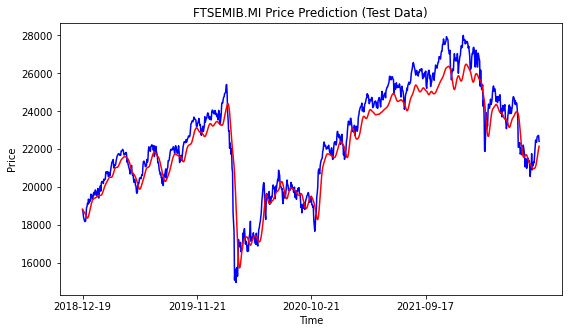

In [ ]:
ftsemib.fit_and_test(days_forward = 1)
ftsemib.plot_results()

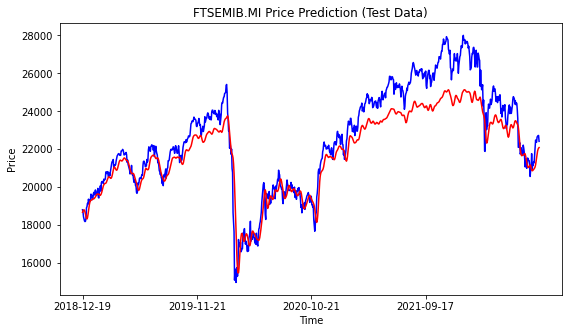

In [ ]:
ftsemib.fit_and_test(days_forward = 20)
ftsemib.plot_results()

In [ ]:
ftsemib.__get_params__()

{'code': 'FTSEMIB.MI',
 'days_forward': 20,
 'end_to_date': '2022-08-11',
 'interval': 'd',
 'load_model': False,
 'n_epochs': 15,
 'n_layers': 4,
 'path_load': 'model_saved',
 'split_val': 2154,
 'start_from_date': '2010-07-01',
 'time_stamps': 30,
 'training_to_test_ratio': 0.7}

In [ ]:
ftsemib.save_model()

Loading model from model_saved


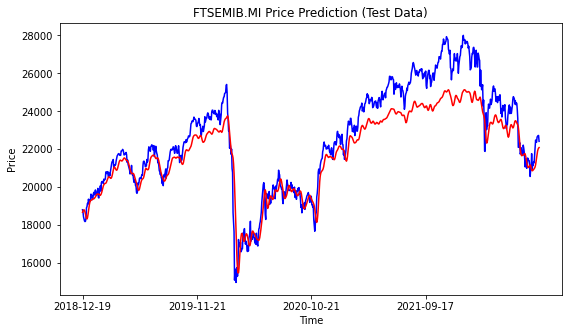

In [ ]:
ftsemib = Price_Predictor('FTSEMIB.MI', load_model=True)
ftsemib.fit_and_test(days_forward = 20)
ftsemib.plot_results()

In [ ]:
ftsemib.predict()

No Input sequence provided, the last 30 records of the data downloaded will be used instead.



In 20 day(s) the price will be: 22071.81


22071.81

In [ ]:
test_input = ftsemib.df['Open'].values[:40]
ftsemib.predict(input_sequence=test_input)



In 20 day(s) the price will be: 20081.227


20081.227

In [ ]:
test_input = ftsemib.df['Open'].values[:21]
ftsemib.predict(input_sequence=test_input)

#it should give ValueError

ValueError: ignored

In [ ]:
ftsemib_next_4_days = Predict_Iterator('FTSEMIB.MI')

In [ ]:
ftsemib_next_4_days.get_predictions(days_to_predict = 4)

[21803.406, 22347.514, 21859.459, 22726.752]

In [ ]:
ftsemib_next_4_days.__get_params__()

{'code': 'FTSEMIB.MI',
 'days_forward': 4,
 'end_to_date': '2022-08-11',
 'interval': 'd',
 'load_model': False,
 'n_epochs': 2,
 'n_layers': 2,
 'path_load': 'model_saved',
 'split_val': 2462,
 'start_from_date': '2010-07-01',
 'time_stamps': 30,
 'training_to_test_ratio': 0.8}

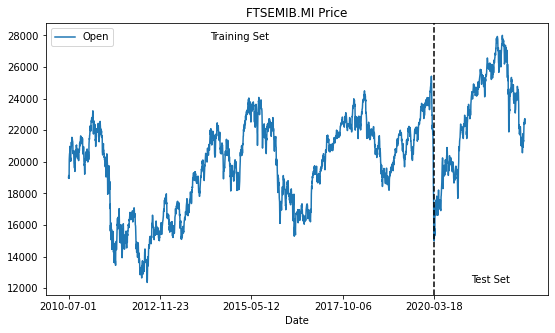

In [ ]:
ftsemib_next_4_days.stored_models[3].plot_data()

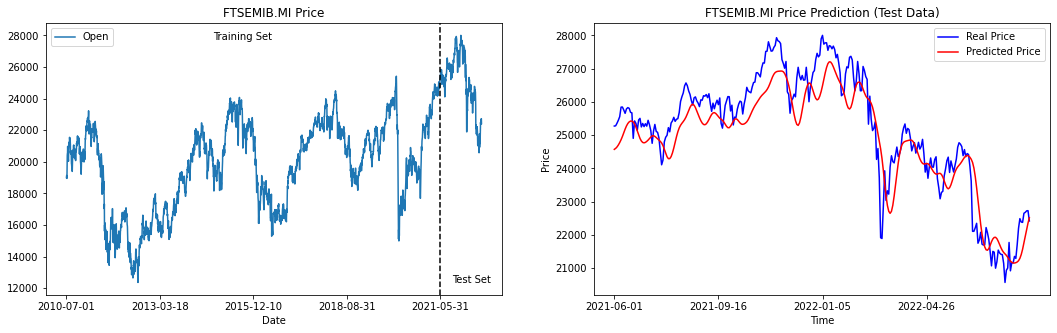

Last price was 22419.00 on 2022-08-10
Next price is predicted to be 22628.611328


(<__main__.Price_Predictor at 0x7f64d6263990>, 22628.611)

In [ ]:
quick_tomorrow('FTSEMIB.MI')

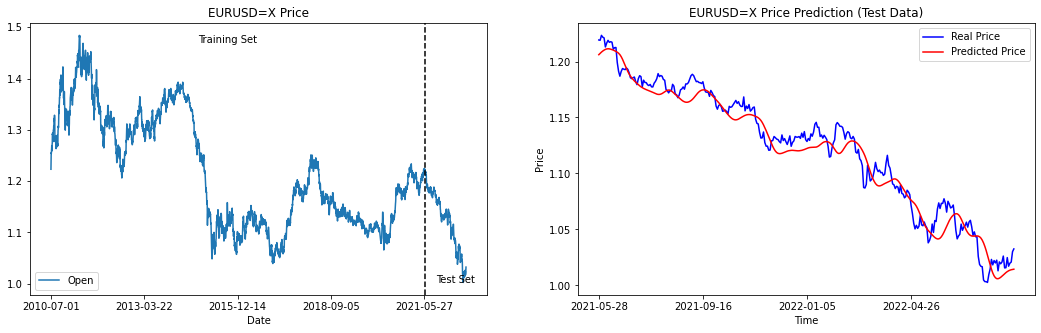

Last price was 1.03 on 2022-08-11
Next price is predicted to be 1.014752


(<__main__.Price_Predictor at 0x7f64da4e8a50>, 1.0147521)

In [ ]:
quick_tomorrow('EURUSD=X')

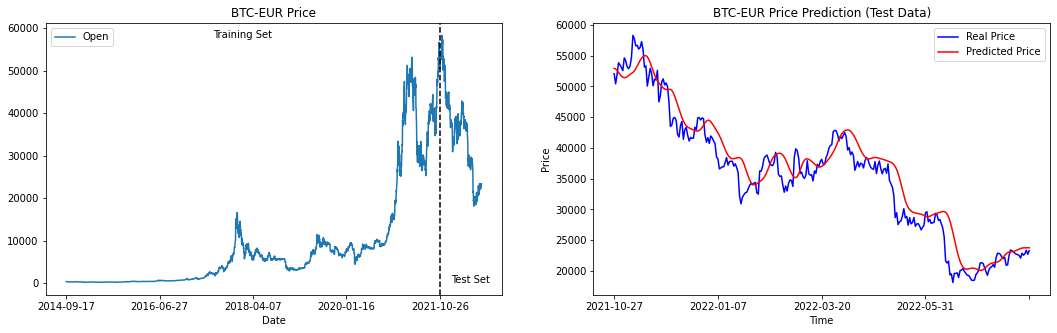

Last price was 23288.64 on 2022-08-11
Next price is predicted to be 23782.962891


(<__main__.Price_Predictor at 0x7f64d5424910>, 23782.963)

In [ ]:
quick_tomorrow('BTC-EUR')

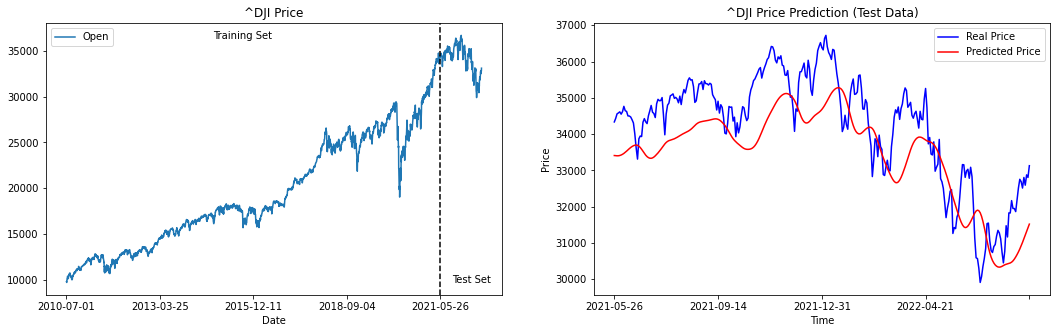

Last price was 33130.63 on 2022-08-10
Next price is predicted to be 31614.486328


(<__main__.Price_Predictor at 0x7f64cf211710>, 31614.486)

In [ ]:
quick_tomorrow('^DJI')

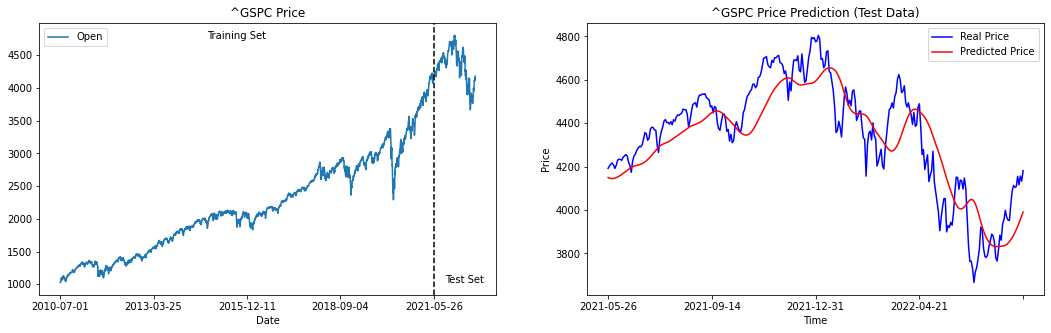

Last price was 4181.02 on 2022-08-10
Next price is predicted to be 4007.295410


(<__main__.Price_Predictor at 0x7f64cd0b9dd0>, 4007.2954)

In [ ]:
quick_tomorrow('^GSPC')

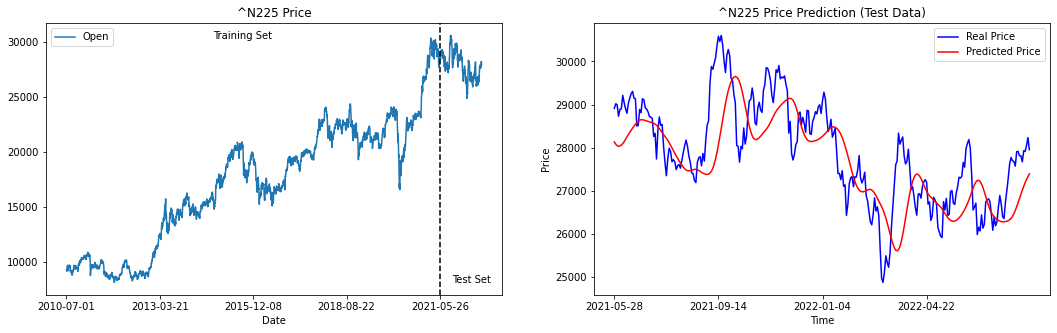

Last price was 27955.11 on 2022-08-10
Next price is predicted to be 27452.755859


(<__main__.Price_Predictor at 0x7f64cb007a50>, 27452.756)

In [ ]:
quick_tomorrow('^N225')

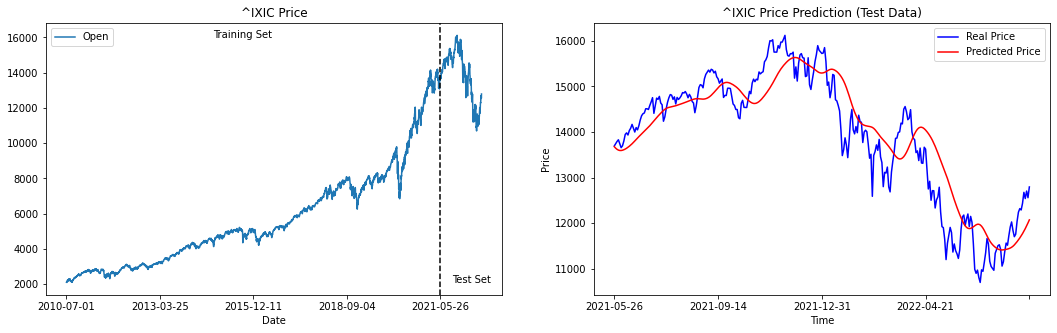

Last price was 12793.44 on 2022-08-10
Next price is predicted to be 12140.047852


(<__main__.Price_Predictor at 0x7f64c89a0150>, 12140.048)

In [ ]:
quick_tomorrow('^IXIC')

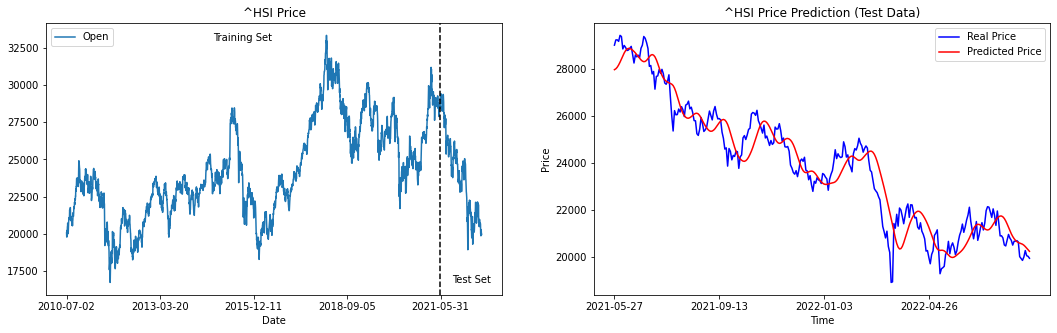

Last price was 19956.51 on 2022-08-10
Next price is predicted to be 20187.669922


(<__main__.Price_Predictor at 0x7f64c68f1810>, 20187.67)

In [ ]:
quick_tomorrow('^HSI')

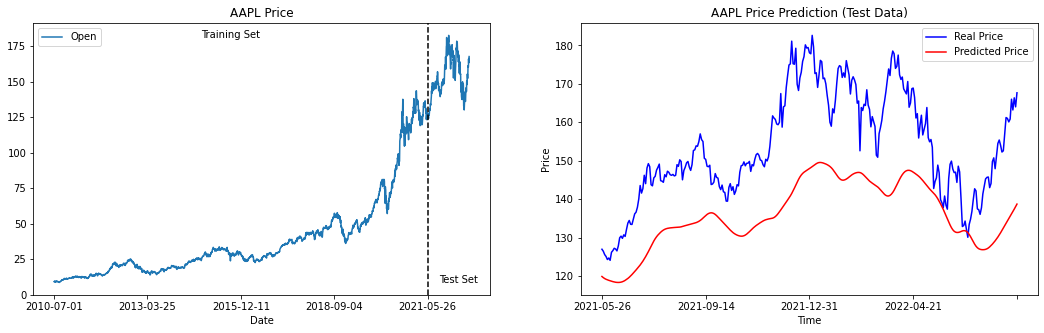

Last price was 167.68 on 2022-08-10
Next price is predicted to be 139.353241


(<__main__.Price_Predictor at 0x7f64c42f70d0>, 139.35324)

In [ ]:
quick_tomorrow('AAPL')

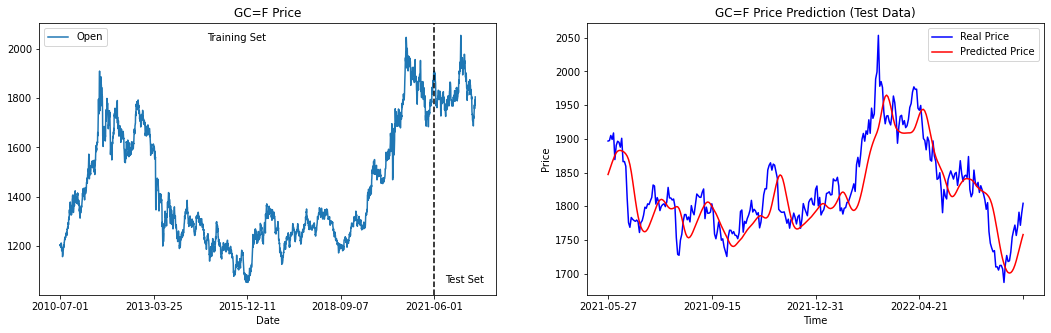

Last price was 1804.40 on 2022-08-10
Next price is predicted to be 1764.765625


(<__main__.Price_Predictor at 0x7f64c1c75ad0>, 1764.7656)

In [ ]:
quick_tomorrow('GC=F')

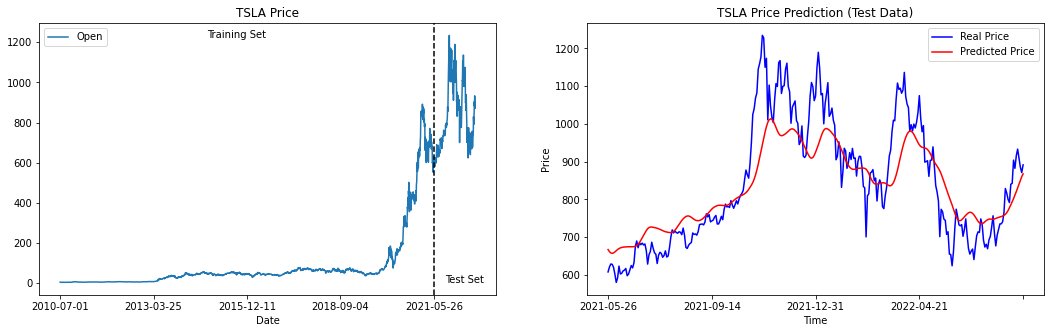

Last price was 891.20 on 2022-08-10
Next price is predicted to be 872.820923


(<__main__.Price_Predictor at 0x7f64bfdc2ed0>, 872.8209)

In [ ]:
quick_tomorrow('TSLA')

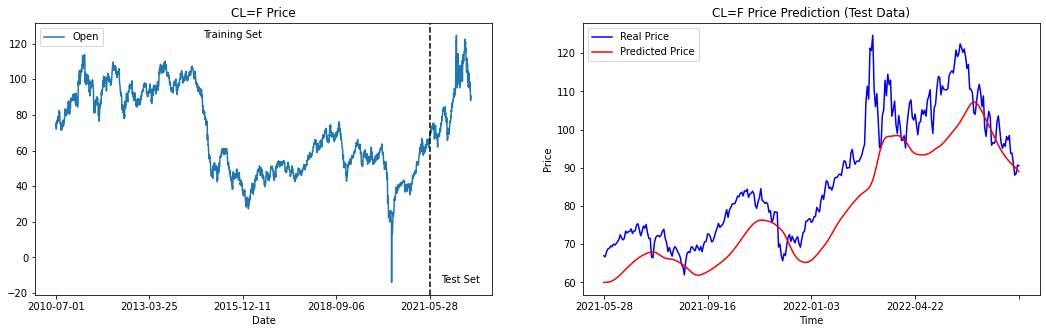

Last price was 90.51 on 2022-08-10
Next price is predicted to be 88.494263


(<__main__.Price_Predictor at 0x7f64bd8c1890>, 88.49426)

In [ ]:
quick_tomorrow('CL=F')

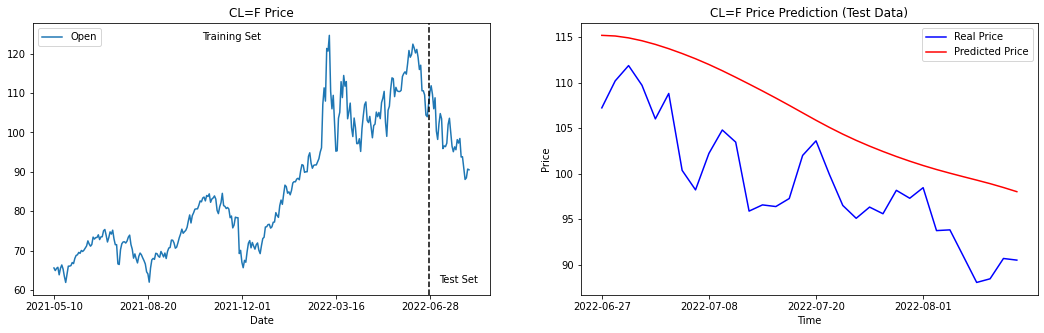

Last price was 90.51 on 2022-08-10
Next price is predicted to be 97.534561


(<__main__.Price_Predictor at 0x7f64bb0df2d0>, 97.53456)

In [ ]:
quick_tomorrow('CL=F', start_from_date = '2021-05-08')

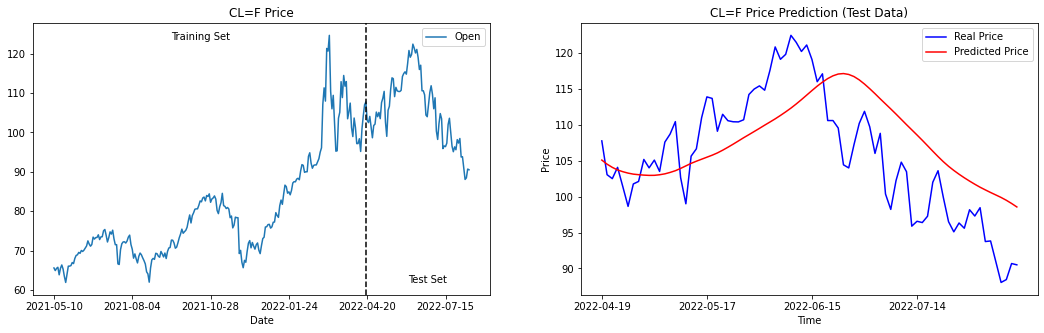

Last price was 90.51 on 2022-08-10
Next price is predicted to be 98.039757


(<__main__.Price_Predictor at 0x7f64b8fce510>, 98.03976)

In [ ]:
quick_tomorrow('CL=F', start_from_date = '2021-05-08', training_to_test_ratio = 0.75)